In [24]:
from irrep.bandstructure import BandStructure

import numpy as np
import scipy
from wannierberri.symmetry.projections import Projection, ProjectionsSet
from wannierberri.w90files import Wannier90data

bands_pw = np.loadtxt("./data/Fe_bands_pw.dat")
bohr_ang = scipy.constants.physical_constants['Bohr radius'][0] / 1e-10
alatt = 5.4235* bohr_ang
bands_pw[:,0]*= 2*np.pi/alatt



bandstructure = BandStructure(code="espresso", 
                              prefix="./data/Fe",
                              normalize=False,
                              irreducible=True,
                              include_TR=True,
                            #   select_grid=[2,2,2],  # Try to uncomment this line to reduce the grid
                              magmom = [[0,0,1]]
                              )
sg = bandstructure.spacegroup
# sg.show()


positions_atoms = [[0,0,0]] 
proj_s = Projection(position_num=positions_atoms, orbital="s", spacegroup=sg)
proj_p = Projection(position_num=positions_atoms, orbital="p", spacegroup=sg)
proj_d = Projection(position_num=positions_atoms, orbital="d", spacegroup=sg)

projection_sp3d2 = Projection(orbital='sp3d2', position_num=[0, 0, 0], spacegroup=sg)
projection_t2g = Projection(orbital='t2g', position_num=[0, 0, 0], spacegroup=sg)

projections = ProjectionsSet(projections=[projection_sp3d2, projection_t2g])
# projections = ProjectionsSet([proj_s, proj_p, proj_d])


w90data = Wannier90data().from_bandstructure(bandstructure, 
                                             projections=projections, 
                                             files=["mmn",  "amn", "eig", "symmetrizer"], 
                                             normalize=False,
                                             irreducible=True,
                                             read_npz_list=[],
                                             write_npz_list=[])


froz_max=19
# w90data.select_bands(win_min=-np.inf, win_max = 100)

w90data.wannierise(
                init = "amn",
                froz_min=-np.inf,
                froz_max=froz_max,
                print_progress_every=10,
                num_iter=101,
                conv_tol=1e-6,
                mix_ratio_z=1.0,
                sitesym=True,
                )


finding num points from 2 projections
got irreducible=True, mp_grid=None, seedname=wannier90, files=['mmn', 'amn', 'eig', 'symmetrizer'], read_npz_list=[], write_npz_list=[], projections=ProjectionsSet with 9 Wannier functions and 0 free variables
Projection 0, 0, 0:['sp3d2'] with 6 Wannier functions on 1 points (6 per site)
Projection 0, 0, 0:['t2g'] with 3 Wannier functions on 1 points (3 per site), unk_grid=None, normalize=False
self.irreducible=True
mpgrid = [4 4 4], 13
grid: (np.int64(4), np.int64(4), np.int64(4)), selected_kpoints: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
kptirr: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
restored kpt_latt_grid: [[ 0.    0.    0.  ]
 [ 0.    0.    0.25]
 [ 0.    0.   -0.5 ]
 [ 0.    0.25 -0.5 ]
 [ 0.25  0.25  0.25]
 [ 0.25  0.25 -0.5 ]
 [ 0.25 -0.25  0.25]
 [-0.5  -0.5  -0.5 ]
 [ 0.    0.25  0.  ]
 [ 0.   -0.5   0.  ]
 [ 0.   -0.75 -0.25]
 [ 0.25  0.25 -0.25]
 [ 0.25 -0.5  -0.25]
 [ 0.    0.   -0.25]
 [ 0.25  0.    0.  ]
 [-0.25  0.    0.  ]
 [ 0.2

/home/stepan/github/wannier-berri-work/wannier-berri-eig-mmn/wannierberri/wannierise/wannierizer.py:230: UserWarning: Ray is not initialized, running in serial mode
  warnings.warn("Ray is not initialized, running in serial mode")


####################################################################################################
starting WFs
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
 -0.194340000000    0.000000000000   -0.000000000000   |     2.579102881140
 -0.160095000000   -0.000000000000   -0.000000000000   |     2.844573181804
  0.194340000000   -0.000000000000    0.000000000000   |     2.579102881140
  0.160095000000   -0.000000000000   -0.000000000000   |     2.844573181804
 -0.000000000000   -0.194340000000    0.000000000000   |     2.579102881140
 -0.000000000000   -0.160095000000    0.000000000000   |     2.844573181804
  0.000000000000    0.194340000000   -0.000000000000   |     2.579102881140
 -0.000000000000    0.160095000000    0.000000000000   |     2.844573181804
 -0.000000000000   -0.000000000000   -0.19709700

setting Rvec
expjphase1 (1, 18, 12)
Real-space lattice:
 [[ 1.4349963  1.4349963  1.4349963]
 [-1.4349963  1.4349963  1.4349963]
 [-1.4349963 -1.4349963  1.4349963]]
Number of wannier functions: 18
Number of R points: 89
Recommended size of FFT grid [4 4 4]
Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x7282bc1ada60>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x7282c586b920> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x7282bc1ada60>
All 

<>:13: SyntaxWarning: invalid escape sequence '\G'
<>:13: SyntaxWarning: invalid escape sequence '\G'
<>:13: SyntaxWarning: invalid escape sequence '\G'
<>:13: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_611910/3141105817.py:13: SyntaxWarning: invalid escape sequence '\G'
  labels = ["$\Gamma$", "H", "P", "N", "$\Gamma$"],
/tmp/ipykernel_611910/3141105817.py:13: SyntaxWarning: invalid escape sequence '\G'
  labels = ["$\Gamma$", "H", "P", "N", "$\Gamma$"],
/home/stepan/github/wannier-berri-work/wannier-berri-eig-mmn/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing    536 K-points in serial:     0.4869 ; per K-point          0.0009 ; proc-sec per K-point          0.0009
time1 =  0.01200246810913086
Totally processed 536 K-points 
run() finished


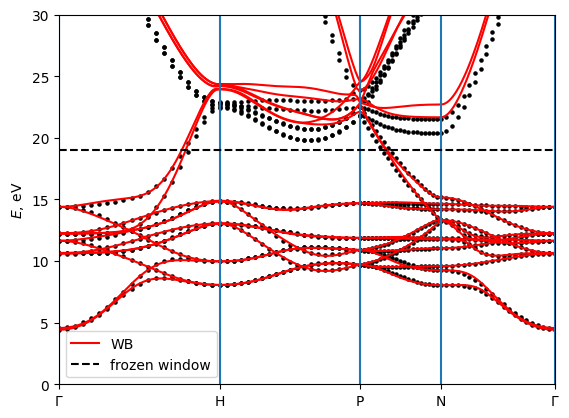

In [25]:
from matplotlib import pyplot as plt
from wannierberri.grid import Path
from wannierberri import evaluate_k_path
from wannierberri.system import System_w90
system = System_w90(w90data=w90data)

path = Path(system=system,
            nodes = [[0.0000, 0.0000, 0.0000 ],  #  G 
                     [0.500 ,-0.5000, -0.5000],  #  H 
                     [0.7500, 0.2500, -0.2500],  #  P 
                     [0.5000, 0.0000, -0.5000],  #  N 
                     [0.0000, 0.0000, 0.000  ]],  #  G 
            labels = ["$\Gamma$", "H", "P", "N", "$\Gamma$"],
            length=500)

bands_wb = evaluate_k_path(system=system, path=path)

plt.scatter(bands_pw[:,0], bands_pw[:,1], c="black", s=5)



bands_wb.plot_path_fat(path,
                quantity=None,
                # save_file="Fe_bands.pdf",
                Eshift=0,
                Emin=0, Emax=30,
                iband=None,
                mode="fatband",
                fatfactor=20,
                cut_k=False,
                linecolor="red",
                close_fig=False,
                show_fig=False,
                label=f"WB"
                )

# plt.ylim(-10, 40)
plt.hlines(froz_max, 0, bands_pw[-1,0], linestyles="dashed", label="frozen window", color="black")
plt.legend()
plt.show()